In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from nn_tools import Qfirst, Qfollowing, optimiers_list, one_batch_layers, EarlyStoppingList
import torch.nn as nn
from learning_tools import peak_one, algo_p, algo_e, update, assess_models
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
def init_variables(nb_layers, include_early_stopping, min_es_list, patience_es_list, init_models, Q_models = None):
    D = [[torch.empty(0), torch.empty(0)] for _ in range(nb_layers)]  # Un dataset D par couche
    all_actions = list(range(36))  # 36 actions possibles
    if init_models:
        Q_models = [Qfirst() if i == 0 else Qfollowing() for i in range(nb_layers)]
    losses=[]
    val_losses = []
    if include_early_stopping:
        early_stop_list = EarlyStoppingList(min_es_list, patience_es_list)
    else:
        early_stop_list = None
    return D, all_actions, Q_models, losses, val_losses, early_stop_list


def augment_dataset(data, Q_models, nb_layers, D, epsilon, all_actions):
    bidding_history = np.zeros(36) # array de 5x36 pour enregistrer l'historique des enchères
    x1, x2, scores = peak_one(data)

    for j in range(nb_layers):
        C = np.zeros(36)  
        hand = x1 if (j+1) % 2 == 1 else x2  # main du joueur actuel

        #### Calcul des coûts des actions: policy evaluation ####
        for i, action in enumerate(all_actions):
            C[i] = algo_p(action,x1,x2,scores,bidding_history,Q_models,nb_layers)
        
        # state = main si première couche sinon state = main + enchère_précédente
        state = torch.tensor(hand, dtype=torch.float32) if j == 0 else torch.tensor(np.concatenate([hand, bidding_history]), dtype=torch.float32)
        D=update(D,state,C,j) #ajout de l'expérience dans le dataset D_j
        
        #### Exploration ####
        next_a = algo_e(Q_models[j], state, epsilon, all_actions)  # Sélection avec Q_j
        if next_a == len(bidding_history) - 1:  # si l'action est PASS
            break  
        bidding_history[next_a] = 1  # enregistrement de l'action choisie dans l'historique des enchères
    return D


def remove_lines(D, max_length, offset):
    for k in range(len(D)):
        if D[k][0].shape[0]>max_length:
            D[k][0]=D[k][0][offset:]
            D[k][1]=D[k][1][offset:]
    return D


def train_models(Q_models, D, loss, losses, batch_size, device):
    opti_list=optimiers_list(Q_models)
    losses.append(one_batch_layers(Q_models, D, opti_list,loss, batch_size, device))
    return losses

def update_validation_loss(Q_models, val_dataset, val_losses, nb_iteration, include_early_stopping, early_stop_list = None):
    if nb_iteration%1000 == 0:
        val_losses.append(assess_models(Q_models, val_dataset))
        if include_early_stopping and nb_iteration > 100000 \
            and early_stop_list.test_stop(val_losses[-1], [Q.state_dict() for Q in Q_models]):
            early_stop_list.set_best_weights(Q_models)
            return val_losses, True
    return val_losses, False


def plot_losses(losses, offset = 0):
    _, axs = plt.subplots(1,losses.shape[1], figsize = (4*losses.shape[1], 4))

    for k in range(losses.shape[1]):
        if not np.all(np.isnan(losses[offset:,k])):
            sns.lineplot(losses[offset:,k], ax=axs[k])
            axs[k].set_title(f"Loss {k}th layer")
            axs[k].set_yscale('log')
    plt.tight_layout()
    plt.show()

In [11]:
def learning_algo(data, val_dataset, max_iter=100, nb_layers=5, epsilon=0.1,
                  init_models = True, Q_models = None,
                  include_early_stopping = True, min_es_list = [1e-2]*5, patience_es_list = [100]*5,
                  loss= nn.MSELoss(),batch_size=50, device='cpu'):
    
    D, all_actions, Q_models, losses, val_losses, early_stop_list \
        = init_variables(nb_layers, include_early_stopping, min_es_list, patience_es_list, init_models, Q_models)
    
    for number_iteration in tqdm(range(max_iter)):
        D = augment_dataset(data, Q_models, nb_layers, D, epsilon, all_actions)
        if number_iteration > 1000000:
            D = remove_lines(D, 1000000, 100000)
        losses = train_models(Q_models, D, loss, losses, batch_size, device)
        val_losses, stop = update_validation_loss(Q_models, val_dataset, val_losses, number_iteration, include_early_stopping, early_stop_list)
        if stop:
            break
    return Q_models, np.array([np.array(l) for l in losses]), np.array([np.array(l) for l in val_losses])

In [12]:
data = pd.concat([pd.read_csv(f"data/slice{k}.csv", index_col = 0) for k in range(10)])
val_dataset = pd.concat([pd.read_csv(f"data/slice{k}.csv") for k in range (10, 12)])

In [13]:
Q_models, losses, val_losses = learning_algo(data, val_dataset, max_iter=10000, include_early_stopping = False)

  0%|          | 0/10000 [00:00<?, ?it/s]

c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = torch.tensor(hand, dtype=torch.float32) if i == 0 else torch.tensor(
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return scores[last_action], last_layer
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:82: RuntimeWarning: invalid value encountered in divide
  return np.a

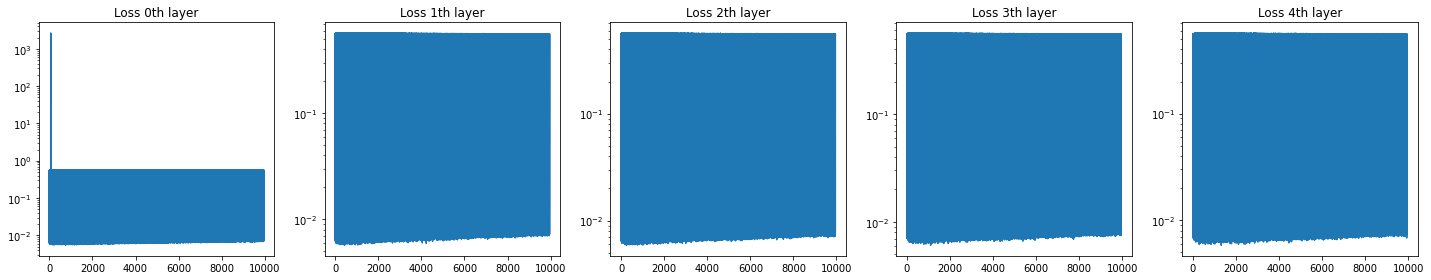

In [14]:
plot_losses(losses, offset=50)

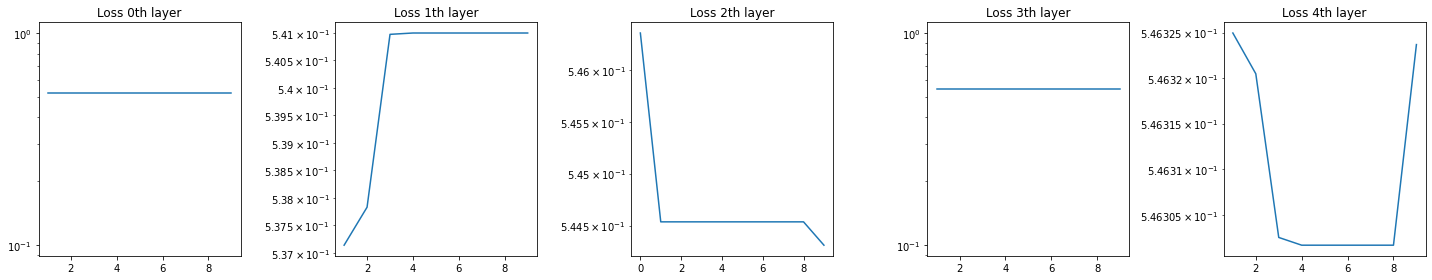

In [15]:
plot_losses(val_losses, offset=0)

In [16]:
Q_models, losses_aux, val_losses_aux = learning_algo(data, val_dataset, max_iter=50000, include_early_stopping = False, init_models=False, Q_models=Q_models)

  0%|          | 0/50000 [00:00<?, ?it/s]c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = torch.tensor(hand, dtype=torch.float32) if i == 0 else torch.tensor(
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return scores[last_action], last_layer
100%|██████████| 50000/50000 [2:00:26<00:00,  6.92it/s]   


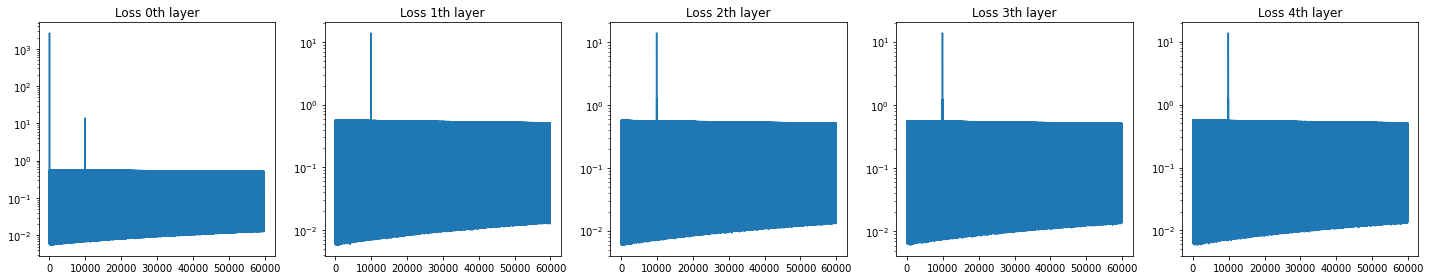

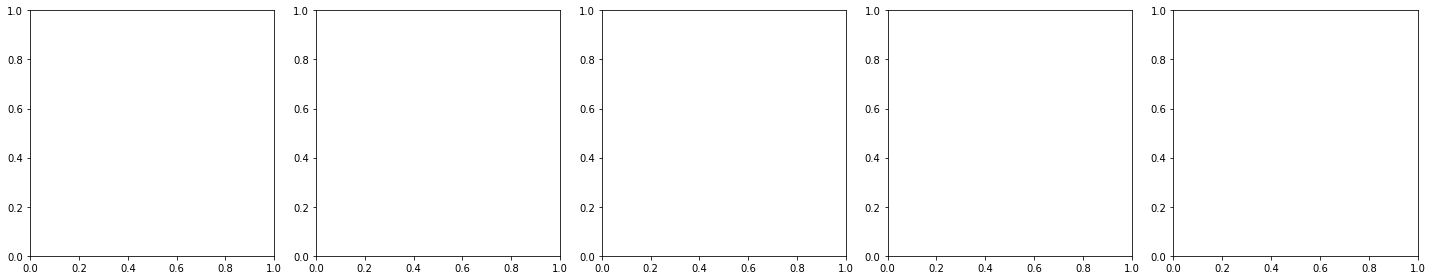

In [ ]:
losses = np.concatenate([losses, losses_aux], axis = 0)
val_losses = np.concatenate([val_losses, val_losses_aux], axis = 0)
plot_losses(losses, offset=100)
plot_losses(val_losses, offset=100)

0


  0%|          | 0/50000 [00:00<?, ?it/s]c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = torch.tensor(hand, dtype=torch.float32) if i == 0 else torch.tensor(
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return scores[last_action], last_layer
 12%|█▏        | 5999/50000 [10:41<45:41, 16.05it/s]    c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridg

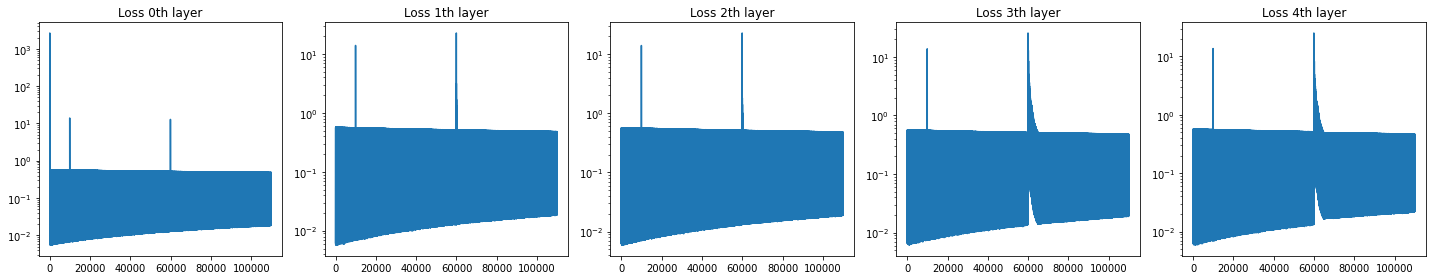

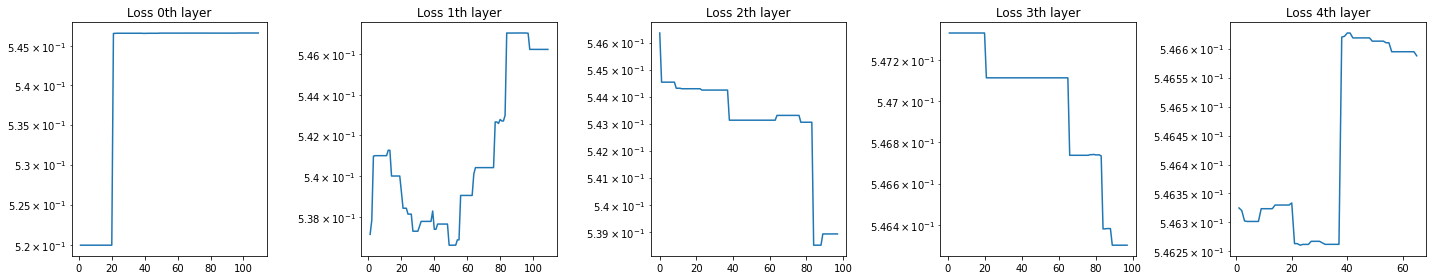

1


  0%|          | 0/50000 [00:00<?, ?it/s]c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = torch.tensor(hand, dtype=torch.float32) if i == 0 else torch.tensor(
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return scores[last_action], last_layer
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:82: RuntimeWarning: invalid 

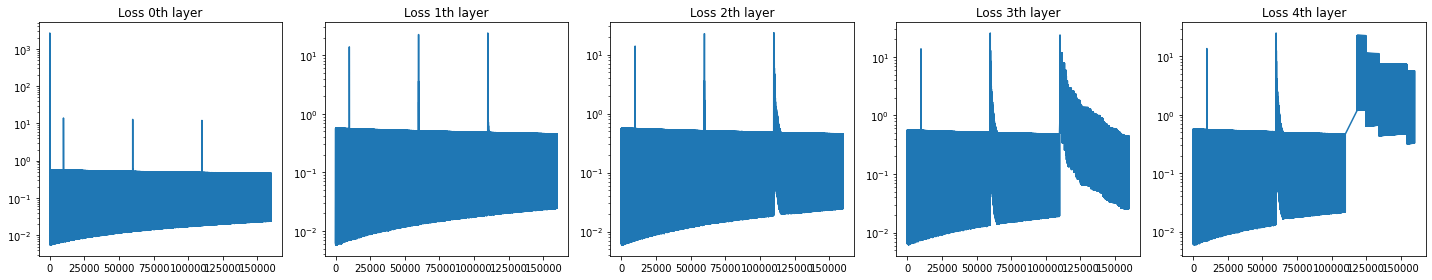

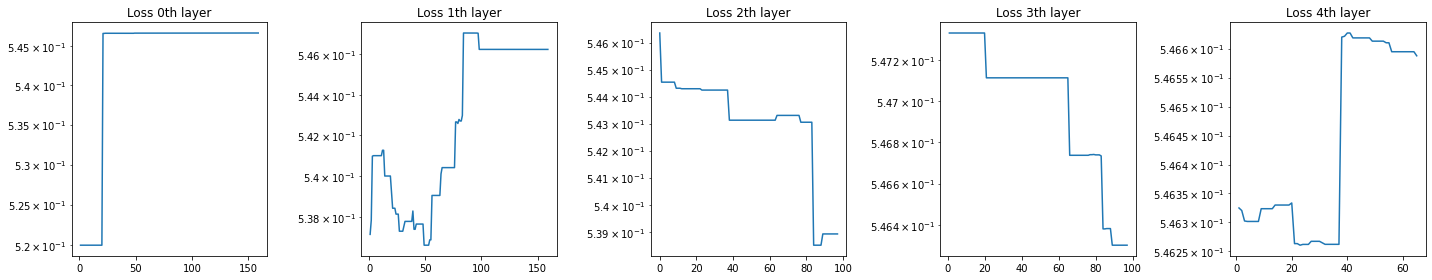

2


  0%|          | 0/50000 [00:00<?, ?it/s]c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = torch.tensor(hand, dtype=torch.float32) if i == 0 else torch.tensor(
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return scores[last_action], last_layer
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:82: RuntimeWarning: invalid 

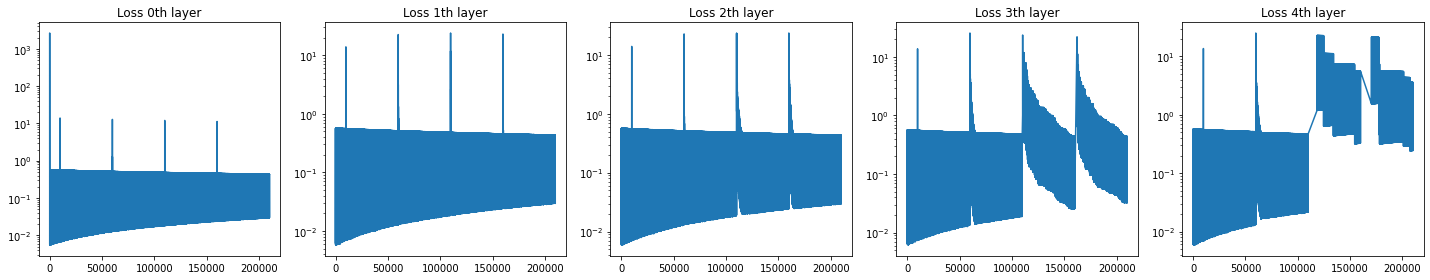

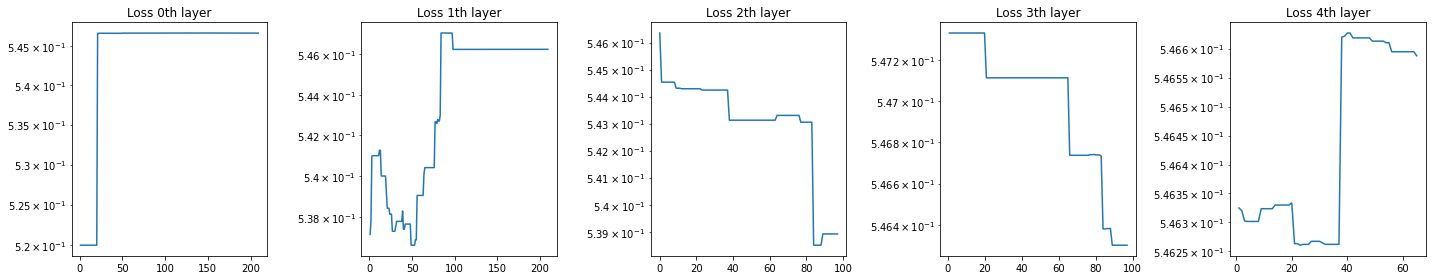

3


  0%|          | 0/50000 [00:00<?, ?it/s]c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = torch.tensor(hand, dtype=torch.float32) if i == 0 else torch.tensor(
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return scores[last_action], last_layer
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:82: RuntimeWarning: invalid 

KeyboardInterrupt: 

In [32]:
for k in range(10):
    print(k)
    Q_models, losses_aux, val_losses_aux = learning_algo(data, val_dataset, max_iter=50000, include_early_stopping = False, init_models=False, Q_models=Q_models)
    losses = np.concatenate([losses, losses_aux], axis = 0)
    val_losses = np.concatenate([val_losses, val_losses_aux], axis = 0)
    plot_losses(losses, offset=100)
    plot_losses(val_losses, offset=0)

100%|██████████| 400000/400000 [21:08:37<00:00,  5.25it/s]      


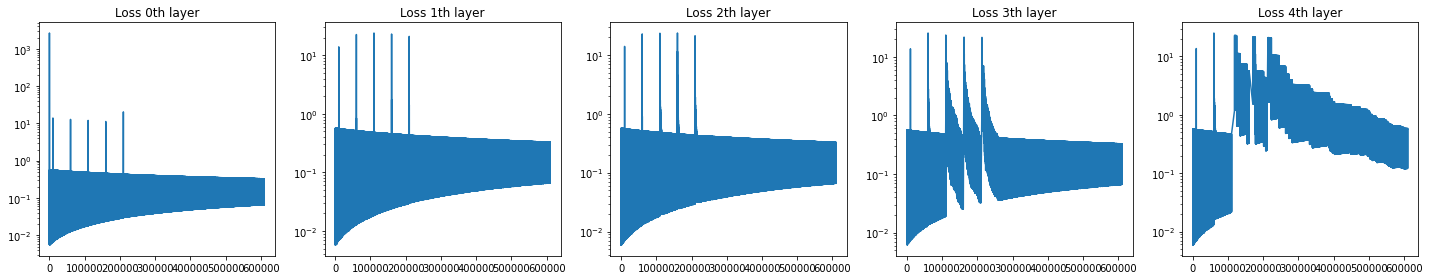

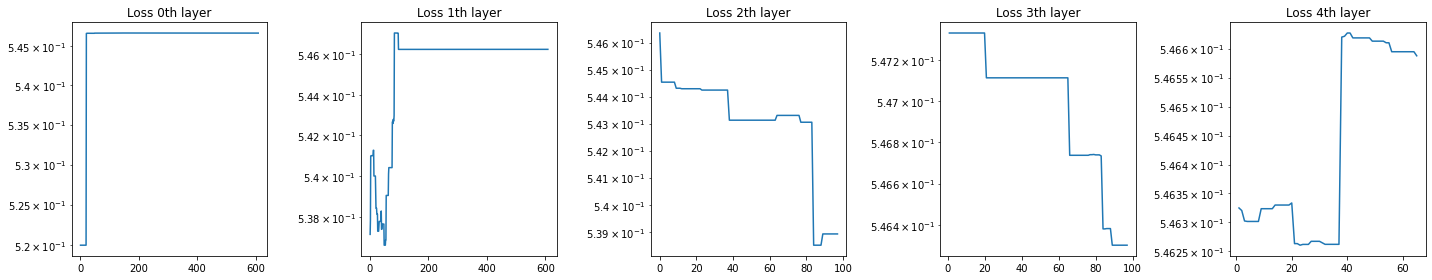

In [38]:
Q_models, losses_aux, val_losses_aux = learning_algo(data, val_dataset, max_iter=400000, include_early_stopping = False, init_models=False, Q_models=Q_models)
losses = np.concatenate([losses, losses_aux], axis = 0)
val_losses = np.concatenate([val_losses, val_losses_aux], axis = 0)
plot_losses(losses, offset=100)
plot_losses(val_losses, offset=0)

  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = torch.tensor(hand, dtype=torch.float32) if i == 0 else torch.tensor(
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return scores[last_action], last_layer
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:82: RuntimeWarning: invalid 

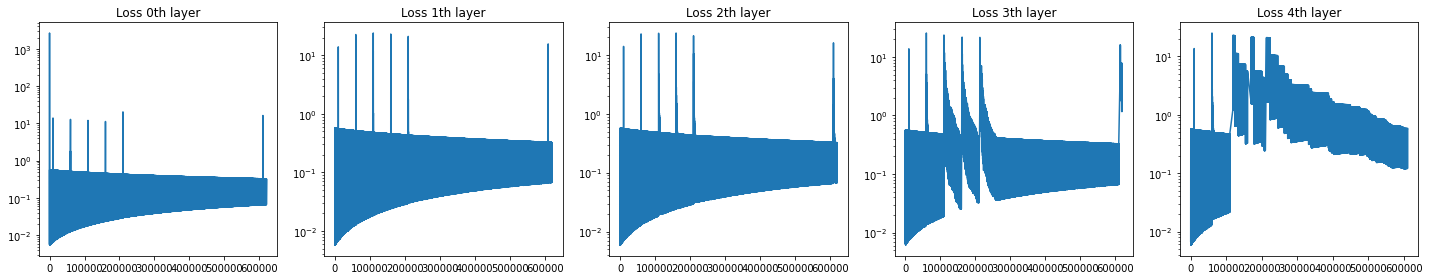

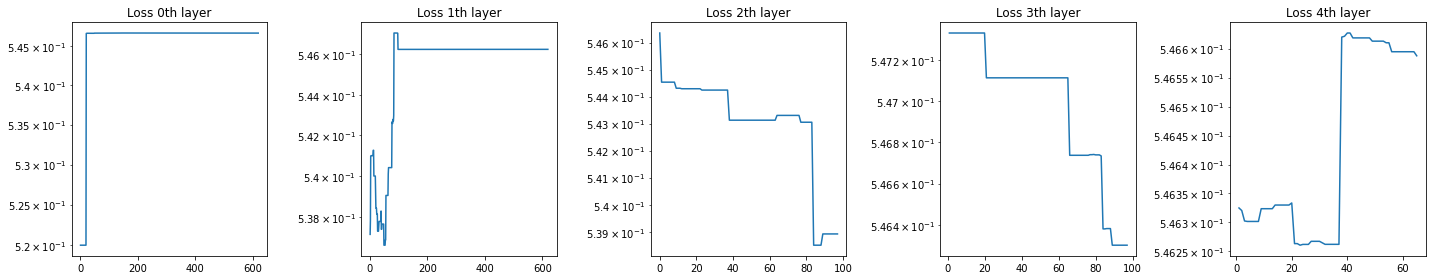

In [41]:
Q_models, losses_aux, val_losses_aux = learning_algo(data, val_dataset, max_iter=10000, include_early_stopping = False, init_models=False, Q_models=Q_models)
losses = np.concatenate([losses, losses_aux], axis = 0)
val_losses = np.concatenate([val_losses, val_losses_aux], axis = 0)
plot_losses(losses, offset=100)
plot_losses(val_losses, offset=0)

In [44]:
test_dataset = pd.concat([pd.read_csv(f"data/slice{k}.csv") for k in range (12, 14)])
results = assess_models(Q_models, test_dataset)
results*25

c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = torch.tensor(hand, dtype=torch.float32) if i == 0 else torch.tensor(
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return scores[last_action], last_layer
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\brige\RL-for-bridge-bidding\learning_tools.py:82: RuntimeWarning: invalid value encountered in divide
  return np.a

array([13.6577675 , 13.68346126,         nan,         nan,         nan])

In [43]:
results

array([0.5463107 , 0.54733845,        nan,        nan,        nan])